<h1> Projet 10: Détectez des faux billets avec R ou Python </h1>

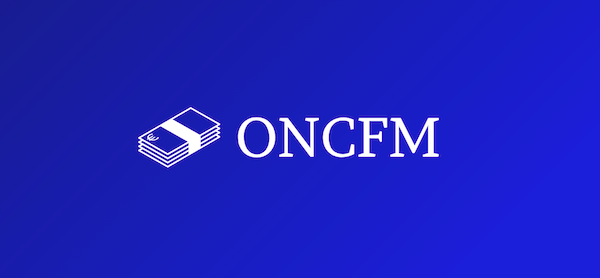

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics, neighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import math
import pickle 

<h1> Import et Exploration Des Données </h1>

In [2]:
#Importation du fichier billets pour notre étude
billets = pd.read_csv(R"~\Documents\OpenClassrooms\Projet 10\data\billets.csv", encoding= "UTF-8", sep=";")
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [3]:
billets.describe(include = 'all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


In [4]:
print(billets.isna().sum())
billets_NAN = billets.loc[billets['margin_low'].isna()]
print(billets_NAN.head())

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64
     is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
72         True    171.94       103.89        103.45         NaN       3.25   
99         True    171.93       104.07        104.18         NaN       3.14   
151        True    172.07       103.80        104.38         NaN       3.02   
197        True    171.45       103.66        103.80         NaN       3.62   
241        True    171.83       104.14        104.06         NaN       3.02   

     length  
72   112.79  
99   113.08  
151  112.93  
197  113.27  
241  112.36  


On retrouve 37 valeurs manquantes dans notre base de donnée

In [5]:
billets_NoNA = billets.dropna()

Dataframe:
<p> billets </p>
<p> billets_NoNA </p>
<p> billets_NAN </p>

<h2> Calcul de Corrélation - billets </h2>

In [6]:
billets.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


D'après le calcul des coefficients de Pearson, on retrouve une corrélation négative plus fortes entre les variables "margin_low" et "length" 

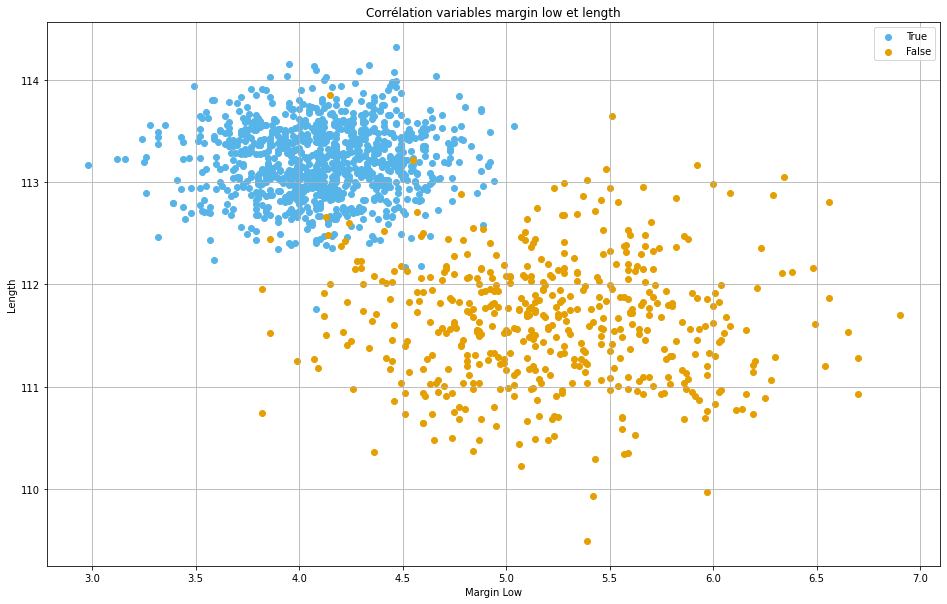

In [7]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.scatter(billets[billets["is_genuine"] == True]["margin_low"],
           billets[billets["is_genuine"] == True]['length'],
           color='#56B4E9')
ax.scatter(billets[billets["is_genuine"] == False]["margin_low"],
           billets[billets["is_genuine"] == False]['length'],
           color='#E69F00')

ax.set_title("Corrélation variables margin low et length")
ax.set_ylabel("Length")
ax.set_xlabel("Margin Low")
ax.legend((True, False))
plt.grid(True)
plt.show()

Par interprétation graphique, on peut observer que les billets considérer comme vrai sont plus concentré que les billets considerer comme faux.

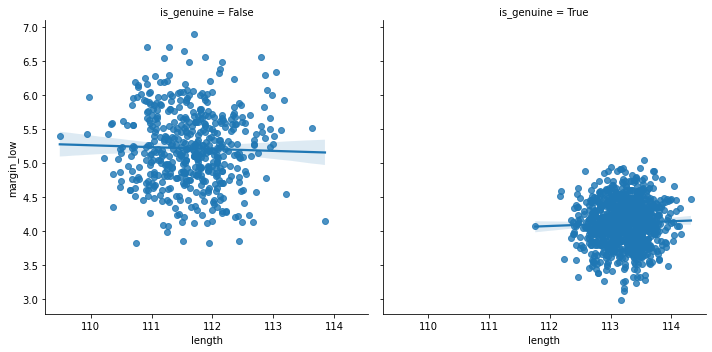

In [8]:
ax = sns.lmplot(x="length", y="margin_low", col="is_genuine", data=billets, palette="Set1")

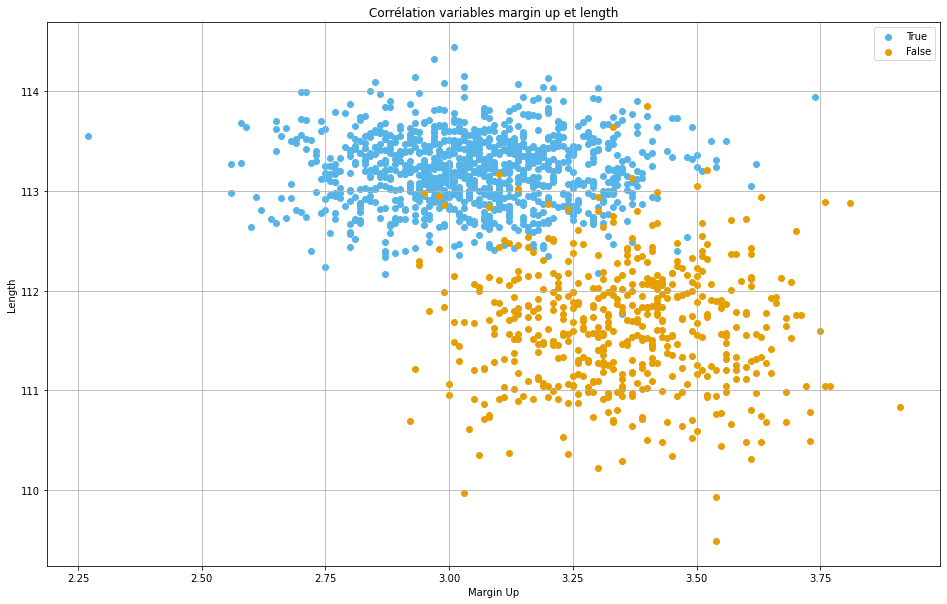

In [9]:
fig, ax = plt.subplots(figsize=(16, 10))

ax.scatter(billets[billets["is_genuine"] == True]["margin_up"],
           billets[billets["is_genuine"] == True]['length'],
           color='#56B4E9')
ax.scatter(billets[billets["is_genuine"] == False]["margin_up"],
           billets[billets["is_genuine"] == False]['length'],
           color='#E69F00')

ax.set_title("Corrélation variables margin up et length")
ax.set_ylabel("Length")
ax.set_xlabel("Margin Up")
ax.legend((True, False))
plt.grid(True)
plt.show()

<h1> Prédiction des Valeurs Manquantes </h1>

Parmis les méthodes disponibles pour estimer les valeurs manquantes, on va utiliser la prediction par regression lineaire pour trouver une estimation plus précise que l'estimation par la moyenne ou la supression des valeurs.

In [10]:
#Préparation valeurs etudier 
xtrain, xtest, ytrain, ytest = train_test_split(
    billets_NoNA.drop(columns='margin_low'),
    billets_NoNA['margin_low'],
    train_size=0.8,
    random_state=42)

Pour notre analyse par regression, on va utiliser 3 méthodes dont la méthode de régression liénaire, la méthode lasso et ridge

In [11]:
models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(alpha=0.1), "Lasso": Lasso(alpha=0.1)}

<h3> Regression Lineaire Classique </h3>

In [12]:
regression = LinearRegression()
regression.fit(xtrain, ytrain)
ypredict = regression.predict(xtest)
print("MSE:", mean_squared_error(ytest, ypredict))
print("r2 score:", r2_score(ytest, ypredict))

MSE: 0.13739452871780822
r2 score: 0.6740384594304604


<h3> Méthode Ridge Regression ou Tikhonov regularization </h3>

In [13]:
regression_Ridge = Ridge(alpha=0.1)
regression_Ridge.fit(xtrain, ytrain)
yridge = regression_Ridge.predict(xtest)
print("MSE:", mean_squared_error(ytest, yridge))
print("r2 score:", r2_score(ytest, yridge))

MSE: 0.13739418390159805
r2 score: 0.6740392774894044


<h3> Méthode Lasso Regression </h3>

In [14]:
regression_Lasso = Lasso(alpha=0.001)
regression_Lasso.fit(xtrain, ytrain)
ylasso = regression_Lasso.predict(xtest)
print("MSE:", mean_squared_error(ytest, ylasso))
print("r2 score:", r2_score(ytest, ylasso))

MSE: 0.1377313090661809
r2 score: 0.6732394651603568


La méthode de régression linéaire semble etre le plus adapté a notre modèle mais n'est pas exacte avec un MSE de 0.13

In [15]:
regression.predict(billets_NAN.drop(columns='margin_low'))

array([4.06938428, 4.10336446, 4.13031141, 3.99396239, 4.12760733,
       4.11389167, 4.07633805, 4.12446936, 4.09906978, 4.08873428,
       4.11992572, 4.17994822, 4.13193146, 4.05745458, 4.18089595,
       4.21229457, 4.11371814, 4.10752426, 4.08102494, 4.10067529,
       4.11570853, 4.13623525, 4.14985075, 4.10660784, 4.12431372,
       4.2008434 , 4.11700616, 4.0824432 , 4.12732375, 5.23959025,
       5.24191591, 5.2705044 , 5.29280389, 5.19827169, 5.16033803,
       5.17695942, 5.2344648 ])

<h3> Imputation valeur manquantes a l'aide de methode de regression lineaire classique </h3>

<h4> On va optimiser notre estimation en passant 5 itération de notre regression </h4>

In [16]:
#It1 (calcul précédent)
It1 = regression.predict(billets_NAN.drop(columns='margin_low'))

#It2
xtrain, xtest, ytrain, ytest = train_test_split(
    billets_NoNA.drop(columns='margin_low'),
    billets_NoNA['margin_low'],
    train_size=0.8,
    random_state=36)
regression.fit(xtrain, ytrain)
It2 = regression.predict(billets_NAN.drop(columns='margin_low'))
#It3
xtrain, xtest, ytrain, ytest = train_test_split(
    billets_NoNA.drop(columns='margin_low'),
    billets_NoNA['margin_low'],
    train_size=0.8,
    random_state=30)
regression.fit(xtrain, ytrain)
It3 = regression.predict(billets_NAN.drop(columns='margin_low'))
#It4
xtrain, xtest, ytrain, ytest = train_test_split(
    billets_NoNA.drop(columns='margin_low'),
    billets_NoNA['margin_low'],
    train_size=0.8,
    random_state=26)
regression.fit(xtrain, ytrain)
It4 = regression.predict(billets_NAN.drop(columns='margin_low'))
#It5
xtrain, xtest, ytrain, ytest = train_test_split(
    billets_NoNA.drop(columns='margin_low'),
    billets_NoNA['margin_low'],
    train_size=0.8,
    random_state=60)
regression.fit(xtrain, ytrain)
It5 = regression.predict(billets_NAN.drop(columns='margin_low'))

In [17]:
nan_imput = np.std( np.array([ It1, It2, It3, It4, It5 ]), axis=0 )
nan_imput

array([0.00825711, 0.00668489, 0.01103125, 0.01070304, 0.00727854,
       0.01630882, 0.00590256, 0.00792113, 0.01115175, 0.00965692,
       0.00880097, 0.01501029, 0.01042423, 0.00944202, 0.00597993,
       0.01183637, 0.00143487, 0.00455863, 0.00520603, 0.00957058,
       0.01230803, 0.01357872, 0.01113274, 0.01199071, 0.00970035,
       0.0086707 , 0.00541344, 0.00774421, 0.00674066, 0.01654166,
       0.01919654, 0.01331422, 0.00993072, 0.02030175, 0.01343691,
       0.02031661, 0.01333162])

In [18]:
# On compare notre modele de prédiction par rapport aux valeurs test
pd.concat([pd.DataFrame(ypredict).reset_index(drop=True), pd.DataFrame(ytest).reset_index(drop=True)], axis=1 ).head()

,0,margin_low
0,5.211443,5.06
1,4.100476,4.30
2,4.117453,5.27
3,4.127238,5.80
4,4.042756,3.99


In [19]:
error_sqr = (ytest-ypredict)**2
error_sqr.sum()
((error_sqr.sum()/len(ytest)))

0.7643174516059803

In [20]:
#On remplace nos valeurs manquantes par nos valeurs prédit
billets.loc[billets["margin_low"].isnull(), 'margin_low'] = nan_imput

In [21]:
billets.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

<h2> Test statistiques de la regression linéaire </h2>

<h3> Etude de la colinéarité </h3>

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

scaler = StandardScaler()

vif_data = pd.DataFrame()
vif_data["feature"] = billets.iloc[:, 1:].columns
vif_data["VIF"] = [
    variance_inflation_factor(scaler.fit_transform(billets.iloc[:, 1:]), i)
    for i in range(6)
]
vif_data

,feature,VIF
0,diagonal,1.013500
1,height_left,1.152358
2,height_right,1.239657
3,margin_low,1.322709
4,margin_up,1.413611
5,length,1.751109


Apres vérifications des valeurs de la variance inflation, on retrouve des valeurs inférieurs à 5 donc on peut conclure qu'il n'y a pas de colinéarité

<h3> Etude Normalité </h3>

In [23]:
rez = regression.fit(xtrain, ytrain)
residues = ytrain-regression.predict(xtrain)
residues_std = residues/np.sqrt(sum(residues**2)/(len(residues)-1))

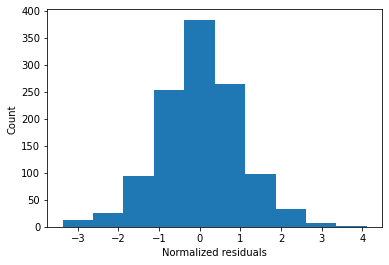

In [24]:
plt.hist(residues_std)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.show()

In [25]:
from scipy import stats
stats.shapiro(residues)

ShapiroResult(statistic=0.9951978921890259, pvalue=0.0009100634488277137)

H0: On suppose que la distribution suit une loi normale
H1: La distribution ne suit pas une loi normale

On retrouve un pvalue inférieure de 0.05, on suppose donc que la distribution ne suit pas de distribution normale.

Notre échantillion est de taille suffisant grand (supérieruer a 30) mais meme si le test hypothese ne valide pas un modele gaussien avec une probabilité de 95%, il n'est pas absurde de l'approximer comme un modele gaussien.

<h3> Etude Homoscédasticité </h3>

In [26]:
sqrt_residues_std = np.sqrt(abs(residues_std))

In [27]:
np.sqrt((residues_std))

C:\Users\JuppC\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


8            NaN
661          NaN
918          NaN
886          NaN
603          NaN
          ...   
101     0.767751
407     0.933177
1455         NaN
1119         NaN
209          NaN
Name: margin_low, Length: 1170, dtype: float64

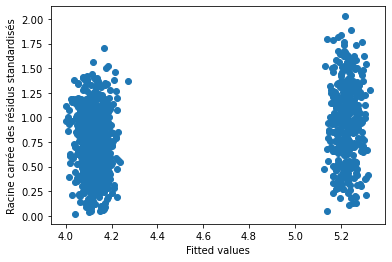

In [28]:
fitted_values = regression.predict(xtrain)

from matplotlib.pyplot import plot, scatter, show, xlabel, ylabel

scatter(fitted_values, sqrt_residues_std)

xlabel("Fitted values")

ylabel("Racine carrée des résidus standardisés")

show()

In [29]:
from statsmodels.stats.diagnostic import het_breuschpagan
het_breuschpagan(residues, scaler.transform(xtrain))

C:\Users\JuppC\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- is_genuine
Feature names seen at fit time, yet now missing:
- margin_low

  warnings.warn(message, FutureWarning)


(388.71542057417577,
 8.019232442319335e-82,
 96.52154103285953,
 1.613433633497909e-98)

H0: On suppose que les variances des résidus sont constante et donc homoscédastique
H1: Les variances des résidus ne sont pas constantes et donc heteroscedastique
Pval(1.613e-98)    
Notre Pvalue est inférieure à 5%, on conclue que les variances des résidus ne sont pas constant et donc heteroscedastique

<h1> Analyse Prédictive Faux Billets</h1>

<h2> Méthode Kmeans </h2>

In [30]:
#On place de nouveau notre jeu de données avec les valeurs prédit ainsi que la conversion de notre colonne is_genuine en int.

data = billets.iloc[:, 1:]
target = billets['is_genuine'].replace(to_replace=[False, True], value=[1, 0])

In [31]:
xtrain, xtest, ytrain, ytest = train_test_split(data, target, train_size=0.8, random_state=36)

In [32]:
#On prend un nombre de cluster de 2
kmeans = KMeans(n_clusters=2, n_init=5, random_state=2)
kmeans.fit(xtrain)
kmeans_clusters = kmeans.labels_

In [33]:
#Coordonnées des centroides 
kmeans_centroid = kmeans.cluster_centers_
kmeans_centroid

array([[171.99494479, 103.95418405, 103.81565644,   3.97719551,
          3.05955828, 113.1775092 ],
       [171.8958961 , 104.19449351, 104.132     ,   5.24067532,
          3.3527013 , 111.58098701]])

In [34]:
kmeans_predicted = kmeans.predict(xtest)
kmeans_predicted

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [35]:
#Comparaison des valeurs test et celle prédit
data_kmeans = pd.concat([
    pd.DataFrame(kmeans_predicted).reset_index(drop=True),
    pd.DataFrame(ytest).reset_index(drop=True)
],
                        axis=1)
data_kmeans.head()

,0,is_genuine
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


<h3> Matrice Confusion Kmeans </h3>

In [36]:
pd.crosstab(data_kmeans[0], data_kmeans["is_genuine"], margins=True)

is_genuine,0,1,All
0,,,
0,204,3,207
1,2,91,93
All,206,94,300


In [37]:
print("Sur un échantillion de 300 valeurs, on retrouve",(ytest != kmeans_predicted).sum(),"mal classées")

Sur un échantillion de 300 valeurs, on retrouve 5 mal classées


<h3> Kmeans Mesure Performance </h3>

In [38]:
print('Precision Score= ', precision_score(ytest, kmeans_predicted))
print('Accuracy Score= ', accuracy_score(ytest, kmeans_predicted))
print('Recall Score= ', recall_score(ytest, kmeans_predicted))

Precision Score=  0.978494623655914
Accuracy Score=  0.9833333333333333
Recall Score=  0.9680851063829787


<h3> Test Algorithmn Kmeans </h3>

In [39]:
billet_eval = pd.read_csv(
    R"~\Documents\OpenClassrooms\Projet 10\billet_test_8.txt",
    encoding="UTF-8",
    sep=",")
billet_eval['Detection'] = kmeans.predict(billet_eval.iloc[:, :6])
billet_eval['Detection'] = billet_eval['Detection'].replace(
    to_replace=[1, 0], value=[False, True])
billet_eval

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Detection
0,171.81,104.86,104.95,4.52,2.89,112.83,C_1,True
1,171.46,103.36,103.66,3.77,2.99,113.09,C_2,True
2,171.76,104.55,103.80,5.28,3.26,111.40,C_3,False
3,172.52,104.11,104.35,5.30,3.31,111.55,C_4,False
4,171.96,103.92,104.23,5.00,3.35,111.16,C_5,False


Notre algorithmn Kmeans a pu détecter correctement la nature des billets de notre fichier d'évaluation.

<h2> Méthode Régression Logistique </h2>

In [40]:
#On place de nouveau notre jeu de données avec les valeurs prédit ainsi que la conversion de notre colonne is_genuine en int.
data = billets.iloc[:, 1:]
target = billets['is_genuine'].replace(to_replace=[False, True], value = [0, 1])

In [41]:
scaler.fit_transform(data)

array([[-0.48653957,  2.77412327,  3.16324041,  0.15128732, -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -0.63434262, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126,  0.02558653, -0.91256208,
         0.55190114],
       ...,
       [-0.51931643, -0.06524991,  0.61346228,  1.18831883,  0.89984645,
        -0.83501554],
       [ 0.3328817 ,  0.83666863,  0.42914097,  0.8321666 ,  1.33137229,
        -0.4911519 ],
       [-1.6009525 ,  0.40241156, -0.30814427,  0.26651304,  0.94299904,
        -0.69747008]])

In [42]:
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=55)

logreg_train =  pd.concat([ytrain, xtrain], axis=1)
logreg_train.head()

In [43]:
logreg = LogisticRegression()
logreg.fit(xtrain, ytrain)
ypredict = logreg.predict(xtest)
print("MSE:", mean_squared_error(ytest, ypredict))
print("r2 score:", r2_score(ytest, ypredict))

MSE: 0.016666666666666666
r2 score: 0.9270569928029566


<h3> Gridsearch pour optimisation de hyperparametre </h3>

<h4> Méthode Régression Logistic </h4>

In [44]:
import warnings

warnings.filterwarnings('ignore')  # parameter grid
parameters = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-4, 4, 50),
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
}

logreg2 = LogisticRegression()
clf = GridSearchCV(
    logreg2,  # model
    param_grid=parameters,  # hyperparameters
    scoring='accuracy',  # metric for scoring
    cv=10)
clf.fit(xtrain, ytrain)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :", clf.best_score_)

Tuned Hyperparameters : {'C': 0.2682695795279725, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.9841666666666669


<h4> Méthode Random Forest </h4>

In [45]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(xtrain, ytrain)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.990833 using {'max_features': 'log2', 'n_estimators': 1000}
0.985278 (0.010690) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.990556 (0.008259) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.990556 (0.008535) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.987222 (0.010259) with: {'max_features': 'log2', 'n_estimators': 10}
0.990000 (0.008975) with: {'max_features': 'log2', 'n_estimators': 100}
0.990833 (0.007862) with: {'max_features': 'log2', 'n_estimators': 1000}


In [46]:
print("score",logreg.score(xtest,ytest))

score 0.9833333333333333


In [47]:
logreg2 = LogisticRegression(C=0.2682695795279725, penalty="l2")
logreg2.fit(xtrain, ytrain)
ypredict2 = logreg2.predict(xtest)
print("MSE:", mean_squared_error(ytest, ypredict2))
print("r2 score:", r2_score(ytest, ypredict2))

MSE: 0.013333333333333334
r2 score: 0.9416455942423653


<h3> Courbe ROC </h3>

Plus notre courbe est proche des valeurs de vrais positif et valeurs faible de faux positif, le mieux il est adapté à notre estimation de faux billetss

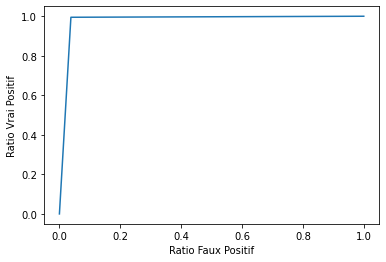

In [48]:
#define metrics
fpr, tpr, _ = metrics.roc_curve(ytest, ypredict)

#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(_))
plt.ylabel('Ratio Vrai Positif')
plt.xlabel('Ratio Faux Positif')
plt.show()

<h3> Calcul de AUC </h3>

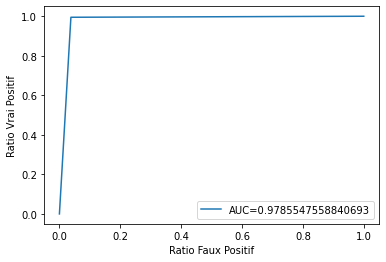

In [49]:
#define metrics
auc = metrics.roc_auc_score(ytest, ypredict)

#create ROC curve
plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('Ratio Vrai Positif')
plt.xlabel('Ratio Faux Positif')
plt.legend(loc=4)
plt.show()

On retrouve un ratio AUC de 0.97 ce qui indique que notre modele est adapté par rapport à notre étude statistiques

In [50]:
print('Mean Absolute Error ( Base):', metrics.mean_absolute_error(ytest, ypredict))  
print('') 

Mean Absolute Error ( Base): 0.016666666666666666



<h3> Prédiction Logistique</h3>

In [51]:
billets_log = list(ypredict)

In [52]:
data_logreg = pd.concat([pd.DataFrame(billets_log).reset_index(drop=True), pd.DataFrame(ytest).reset_index(drop=True)], axis=1 )
data_logreg.head()

,0,is_genuine
0,1,1
1,1,1
2,1,1
3,1,1
4,0,0


<h3> Matrice Confusion </h3>

In [53]:
# Faux = 0, Vrai = 1
pd.crosstab(data_logreg[0], data_logreg["is_genuine"], margins=True)

is_genuine,0,1,All
0,,,
0,102,1,103
1,4,193,197
All,106,194,300


In [54]:
print("Sur un échantillion de 300 valeurs, on retrouve",(ytest != billets_log).sum(),"mal classées")

Sur un échantillion de 300 valeurs, on retrouve 5 mal classées


In [55]:
logreg.coef_[0]

array([ 0.48014806, -0.67580919, -0.99007638, -1.00506243, -1.46207568,
        4.42516311])

<h3> Optimisation du modele par aggregation des itérations </h3>

In [56]:
#It2
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=36)
logreg.fit(xtrain, ytrain)
It2 = logreg.predict(xtest)
print("MSE:", mean_squared_error(ytest, It2))
print("r2 score:", r2_score(ytest, It2))
#It3
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.6,
                                                random_state=75)
logreg.fit(xtrain, ytrain)
It3 = logreg.predict(xtest)
print("MSE:", mean_squared_error(ytest, It3))
print("r2 score:", r2_score(ytest, It3))
#It4
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=12)
logreg.fit(xtrain, ytrain)
It4 = logreg.predict(xtest)
print("MSE:", mean_squared_error(ytest, It4))
print("r2 score:", r2_score(ytest, It4))
#It5
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.6,
                                                random_state=5)
logreg.fit(xtrain, ytrain)
It5 = logreg.predict(xtest)
print("MSE:", mean_squared_error(ytest, It5))
print("r2 score:", r2_score(ytest, It5))

MSE: 0.02
r2 score: 0.9070439991737245
MSE: 0.016666666666666666
r2 score: 0.9257278669043375
MSE: 0.013333333333333334
r2 score: 0.939381693271368
MSE: 0.021666666666666667
r2 score: 0.9034462269756387


In [57]:
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=12)
logreg = LogisticRegression(C=0.2682695795279725, penalty="l2")
logreg.fit(xtrain, ytrain)
ypredict = logreg.predict(xtest)
print("MSE:", mean_squared_error(ytest, ypredict))
print("r2 score:", r2_score(ytest, ypredict))

MSE: 0.01
r2 score: 0.954536269953526


<h3> Regression Logistique Mesure Performance </h3>

In [58]:
print('Precision Score= ', precision_score(ytest, ypredict))
print('Accuracy Score= ', accuracy_score(ytest, ypredict))
print('Recall Score= ', recall_score(ytest, ypredict))

Precision Score=  0.9950248756218906
Accuracy Score=  0.99
Recall Score=  0.9900990099009901


La méthode de regression logistique classique présente un meilleure score dans ses mesures de performances que la méthode kmeans, on utilisera donc cette approche pour notre algorithme de détection.

<h3> Test Algorithme Regression Logisitque </h3>

In [59]:
billet_eval = pd.read_csv(
    R"~\Documents\OpenClassrooms\Projet 10\billet_test_8.txt",
    encoding="UTF-8",
    sep=",")
billet_eval['Detection'] = list(
    map(round, logreg.predict(scaler.transform(billet_eval.iloc[:, :6]))))
billet_eval['Detection'] = billet_eval['Detection'].replace(
    to_replace=[0, 1], value=[False, True])
billet_eval['Probabilité Vrai Billets'] = logreg.predict_proba(
    scaler.transform(billet_eval.iloc[:, :6]))[:, 1]
billet_eval

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Detection,Probabilité Vrai Billets
0,171.81,104.86,104.95,4.52,2.89,112.83,C_1,False,0.205218
1,171.46,103.36,103.66,3.77,2.99,113.09,C_2,True,0.997485
2,171.76,104.55,103.80,5.28,3.26,111.40,C_3,False,0.003506
3,172.52,104.11,104.35,5.30,3.31,111.55,C_4,False,0.006232
4,171.96,103.92,104.23,5.00,3.35,111.16,C_5,False,0.001637


<h1> Test Pour Soutenance </h1>

In [60]:
#It1
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=21)
logreg1 = LogisticRegression(C=0.2682695795279725,
                            penalty='l1',
                            solver='liblinear')
logreg1.fit(scaler.fit_transform(data), target)


#It2
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=36)
logreg2 = LogisticRegression(C=0.2682695795279725,
                            penalty='l1',
                            solver='liblinear')
logreg2.fit(scaler.fit_transform(data), target)
#It3
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=75)
logreg3 = LogisticRegression(C=0.2682695795279725,
                            penalty='l1',
                            solver='liblinear')
logreg3.fit(scaler.fit_transform(data), target)
#It4
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=12)
logreg4 = LogisticRegression(C=0.2682695795279725,
                            penalty='l1',
                            solver='liblinear')
logreg4.fit(scaler.fit_transform(data), target)#It5
xtrain, xtest, ytrain, ytest = train_test_split(scaler.transform(data),
                                                target,
                                                train_size=0.8,
                                                random_state=5)
logreg5 = LogisticRegression(C=0.2682695795279725,
                            penalty='l1',
                            solver='liblinear')
logreg5.fit(scaler.fit_transform(data), target)

LogisticRegression(C=0.2682695795279725, penalty='l1', solver='liblinear')

In [61]:
logreg = LogisticRegression(C=0.2682695795279725,
                            penalty='l1',
                            solver='liblinear')
logreg.fit(scaler.fit_transform(data), target)

LogisticRegression(C=0.2682695795279725, penalty='l1', solver='liblinear')

In [62]:
g = 1
for i in [logreg1, logreg2, logreg3, logreg4, logreg5]:
    with open("logreg"+str(g)+'.pickle', 'wb') as f:
        pickle.dump(i, file=f)
    g+=1

In [63]:
def prediction(billets_test):
    with open("logreg1.pickle", 'rb') as f:
        modele_sout1 = pickle.load(f)
    with open("logreg2.pickle", 'rb') as f:
        modele_sout2 = pickle.load(f)
    with open("logreg3.pickle", 'rb') as f:
        modele_sout3 = pickle.load(f)
    with open("logreg4.pickle", 'rb') as f:
        modele_sout4 = pickle.load(f)
    with open("logreg5.pickle", 'rb') as f:
        modele_sout5 = pickle.load(f)
        
    billet_eval = pd.read_csv(R"~\Documents\OpenClassrooms\Projet 10" + "\\" +
                              billets_test + ".csv")
    billet_eval['Probabilité Vrai Billets'] = (modele_sout1.predict_proba(
        scaler.fit_transform(billet_eval.iloc[:, :6]))[:, 1]+modele_sout2.predict_proba(
        scaler.fit_transform(billet_eval.iloc[:, :6]))[:, 1]+modele_sout3.predict_proba(
        scaler.fit_transform(billet_eval.iloc[:, :6]))[:, 1]+modele_sout4.predict_proba(
        scaler.fit_transform(billet_eval.iloc[:, :6]))[:, 1]+modele_sout5.predict_proba(
        scaler.fit_transform(billet_eval.iloc[:, :6]))[:, 1])/5
    billet_eval['Detection']= ([billet_eval['Probabilité Vrai Billets'][h]>=0.5 for h in range (len(billet_eval))])
    
    return billet_eval

In [64]:
prediction("billets_test (8)")

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Probabilité Vrai Billets,Detection
0,171.81,104.86,104.95,4.52,2.89,112.83,B_1,0.993682,True
1,171.46,103.36,103.66,3.77,2.99,113.09,B_2,0.999994,True
2,171.80,104.01,104.12,5.51,3.36,111.95,B_3,0.001762,False
3,172.06,104.28,104.06,5.17,3.46,112.25,B_4,0.054774,False
4,171.47,104.15,103.82,4.63,3.37,112.07,B_5,0.030277,False
5,171.81,104.86,104.95,4.52,2.89,112.83,B,0.993682,True
